Multivariate time series forecasting is considered one of the most effective techniques for predicting future data. Using Long Short-Term Memory (LSTM) models is a reliable approach for this purpose. The code provided below includes comments indicating where you can make necessary edits to optimize it for your dataset.

When dealing with multivariate time series forecasting, there is a limitation that we can only forecast one value for a column into the future. This limitation arises due to the lack of available data in the corresponding related columns. However, we can work around this limitation by recursively calling the forecasting function and appending the predicted values to the original dataset, using it as input for subsequent predictions.

It's important to note that as we extend the forecast further into the future, the model's predictions may become less accurate and lose their meaningful interpretation. This can result in saturation or oscillating values in the plotted graph. Therefore, it is advisable to limit the forecast to a relatively small number of values, such as a few tens, to maintain reasonable accuracy.

This is one of the best methods for smaller datasets.

In [1]:
# one step prediction
# Note: this piece of code only predicts for one value into the future of the first column.
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Read the csv file
# make sure your dataset has timeseries values in descending order. As the frame for capturing trends
# moves from top to bottom of the dataframe, you will be predicting values after the end of the dataframe
df = pd.read_csv('data.csv') # replace data.csv with your .csv file
df = df.sort_values("months") # change the name of the column accordingly
df = df.reset_index(drop=True)

# Variables for training
# the [1:8] represents the columns that you will be considering for predicition.
cols = list(df)[1:8] # you might have to change this range according to your dataset
print(cols)

df_for_training = df[cols].astype(float)

# Normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []

# Tune n_past value as per requirements
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, :])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

# Define the Autoencoder model
# you can add one more layer of lstm. If you are doing so, replace the current lstm layer's return_sequences by True.
# change the number of Perceptrons in the layers
# replace activation function as required.
model = Sequential()
model.add(LSTM(128, activation="sigmoid" ,input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(trainY.shape[1]))

# replace the optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Fit the model
# you can train for different number of epochs with a diffrent batchsize.
# Note: it is adviced to keep the number of epochs around 5-10 for smaller datasets.
history = model.fit(trainX, trainY, epochs=7, batch_size=16, validation_split=0.1, verbose=1)
train_predictions = model.predict(trainX)

n_days_for_prediction = 1

last_sequence = df_for_training_scaled[-n_past:]
last_sequence = np.reshape(last_sequence, (1, n_past, len(cols)))

# Make prediction for one value in the future
prediction = model.predict(last_sequence)  # shape = (1, 1)

# Perform inverse transformation to rescale back to the original range
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

print("Predicted value for one day in the future:", y_pred_future[0])

['Total Income From Operations', 'Employees Cost', 'Depreciation', 'Other Expenses', 'Other Income', 'Interest', 'Net Profit/(Loss) For the Period']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
3/3 [==============================] - 2s 146ms/step - loss: 1.5684 - val_loss: 0.6875
Epoch 2/7
3/3 [==============================] - 0s 25ms/step - loss: 0.5861 - val_loss: 0.1176
Epoch 3/7
3/3 [==============================] - 0s 22ms/step - loss: 0.6035 - val_loss: 0.1353
Epoch 4/7


In [2]:
# defining a function to be used later for forecasting

def mult_time_pred_lstm(df_for_training):

    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)

    trainX = []
    trainY = []

    n_future = 1   
    n_past = 15 

    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)


    model = Sequential()
    model.add(LSTM(128, activation="sigmoid" ,input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mean_squared_error')


    history = model.fit(trainX, trainY, epochs=7, batch_size=16, validation_split=0.1,verbose = 0)

    n_past = 15
    
    last_sequence = df_for_training_scaled[-n_past:]
    last_sequence = np.reshape(last_sequence, (1, n_past, len(cols)))

    prediction = model.predict(last_sequence)

    prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
    return y_pred_future[0] #returns 1 forecast value for the first column in the dataset


In [3]:
# forecasting for an yr
import pandas as pd

df = pd.read_csv('data.csv')
df = df.sort_values("months")
df = df.reset_index(drop=True)
# Variables for training
cols = list(df)[1:8]
one_yr_preds = {}

# Iterate through each column and make it the first column
for column in cols:
    # Select the current column as the target column
    target_column = column

    # New dataframe with target column as the first column
    df_for_training = df[[target_column] + [col for col in cols if col != target_column]].astype(float)

    pred = mult_time_pred_lstm(df_for_training)
    one_yr_preds[target_column] = round(pred,2)



1/1 [==============================] - 0s 189ms/step


Note: If you want to forecast more than one value, then give the output file as input for the next itteration and change the month value in this code and save the file. repeat the step for more predictions But It's important to note that as we extend the forecast further into the future, the model's predictions may become less accurate and lose their meaningful interpretation. This can result in saturation or oscillating values in the plotted graph. Therefore, it is advisable to limit the forecast to a relatively small number of values, such as a few tens, to maintain reasonable accuracy.

In [4]:
#run this for every yr to append to previous df
df_one_yr_preds = pd.DataFrame([one_yr_preds])
df_one_yr_preds["months"] = '2023-06'
df_combined = pd.concat([df, df_one_yr_preds], ignore_index=True)
df_combined = df_combined.reset_index(drop = True)
# Save the combined DataFrame to a new CSV file
df_combined.to_csv("output.csv", index=False)

Plotting graphs 

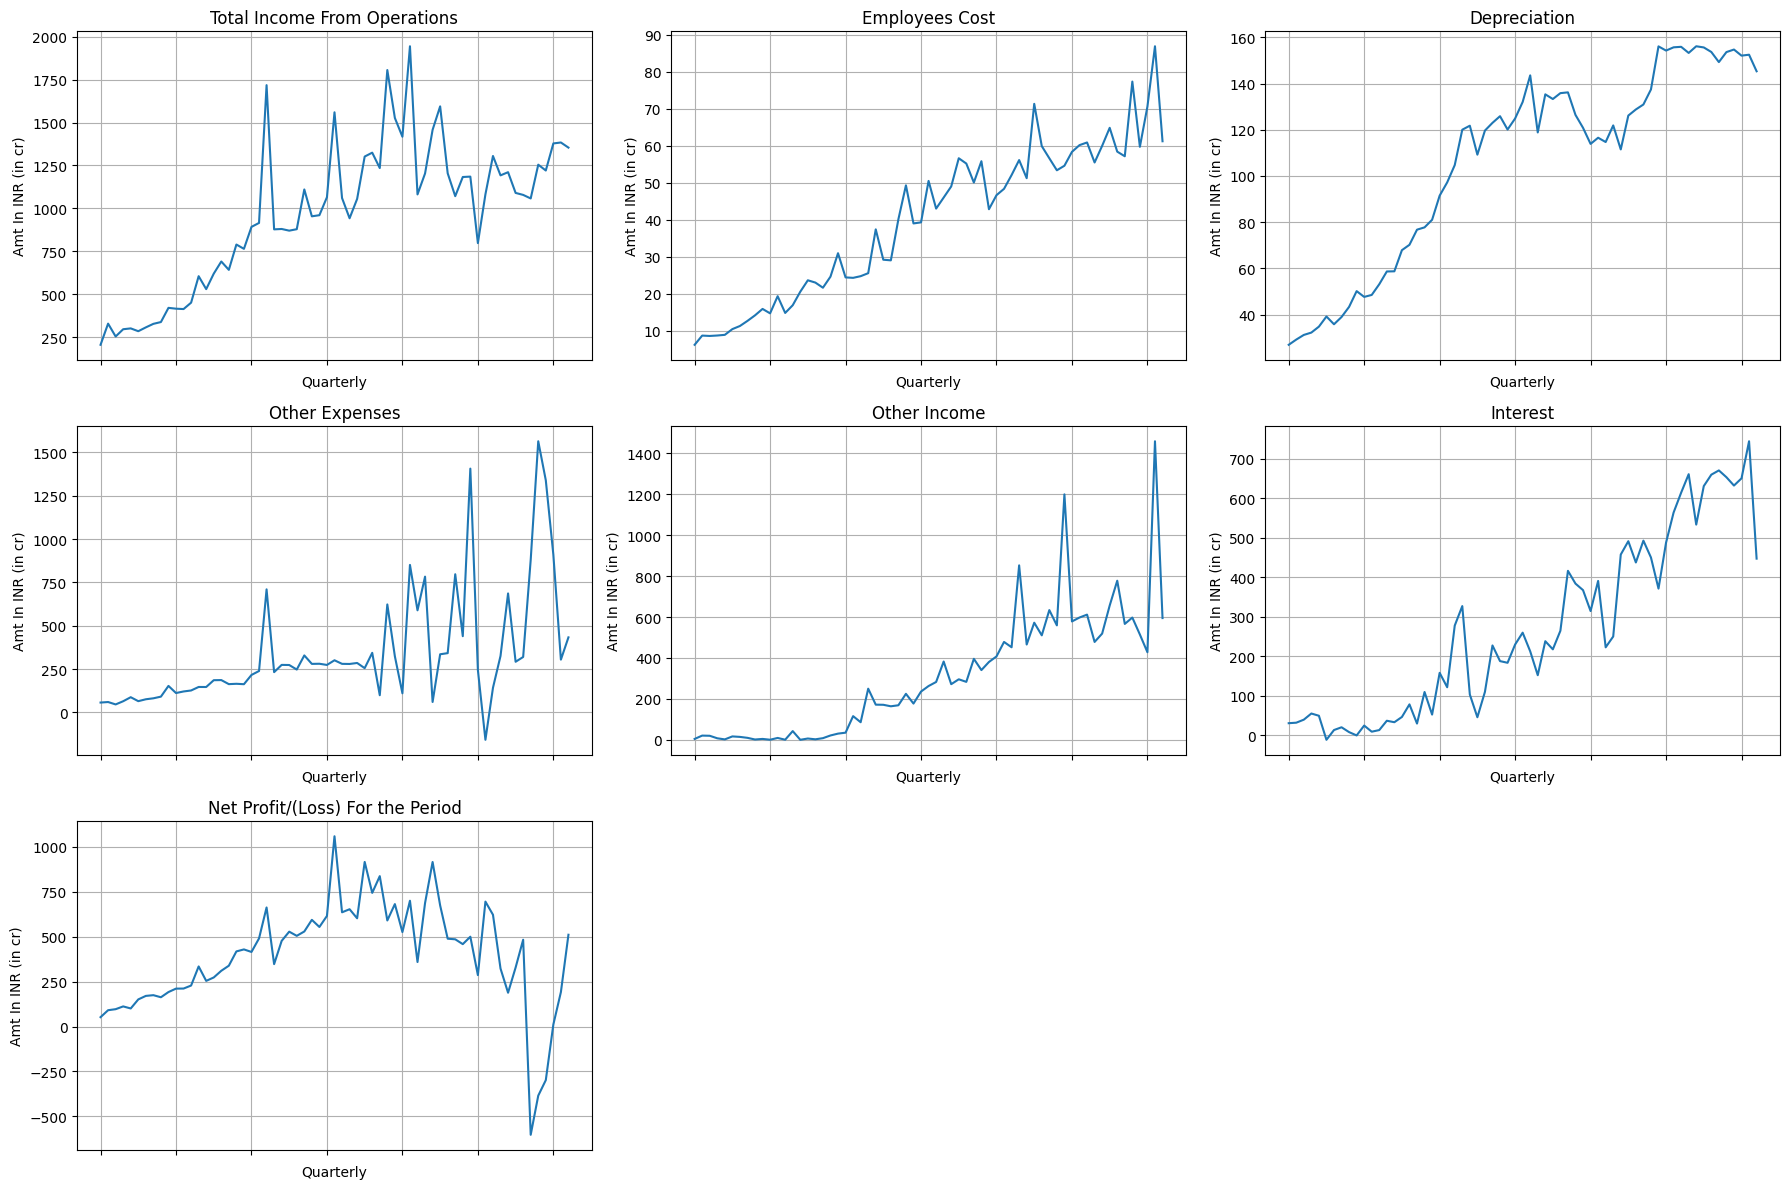

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("output.csv")
def plot_columns_in_grid(df):
    # Exclude the first column
    df = df.iloc[:, 1:]

    # Determine the number of columns and rows in the grid
    num_cols = 3  # Number of columns in the grid
    num_rows = (len(df.columns) - 1) // num_cols + 1  # Number of rows in the grid

    # Calculate the figure size based on the number of rows and columns
    figsize = (num_cols * 6, num_rows * 4)  # Adjust the multipliers to make the graphs bigger

    # Create a figure and axes for the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot each column in a separate graph
    for i, col in enumerate(df.columns):
        ax = axes[i]  # Select the current axis

        # Reverse the x-axis values and index
        x_values = df.index
        y_values = df[col]

        ax.plot(x_values, y_values)
        ax.set_title(col)
        ax.set_xlabel('Quarterly')
        ax.set_ylabel('Amt In INR (in cr)')
        ax.grid(True)

        # Tilt the x-axis tick labels
        ax.tick_params(axis='x', rotation=45)

        # Remove x-axis labels
        ax.set_xticklabels([])

    # Remove any unused axes
    if len(df.columns) < len(axes):
        for j in range(len(df.columns), len(axes)):
            fig.delaxes(axes[j])

    # Adjust spacing between subplots
    fig.tight_layout()

    # Display the grid of graphs
    plt.show()

plot_columns_in_grid(df)

# the x-axis values range from 2004 to 2023 with 3 months gap each. I removed the indexes because it was too crowded